In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
import tensorflow 
from tensorflow import keras
# from keras.applications.resnet import ResNet101V2
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM,GRU
from keras.layers import Dense, Activation,Dropout,TimeDistributed,Bidirectional,AveragePooling1D,Flatten, Reshape
import sys
import h5py
import timeit

print ("Done!")

Done!


In [ ]:
keras.__version__

'2.6.0'

**Helper Functions**
We will use the function print_progress to print the amount of videos processed

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

print ("Done!")

Done!



**Load Data**
The directory to place the video dataset

In [ ]:
in_dir = "data"

in_dir = 'video-dataset-path'

print ("Done!")

print(in_dir)

Done!
/content/drive/My Drive/Colab Notebooks/TRAINING_DATASET_VIOLENCE_REAL_LIFE_HOCKEY_CREATED


**Data-Dimensions**

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

print ("Done!")

Done!



**Helper-function for getting video frames**


USED IN get_transfer_value

In [ ]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)

        image2=cv2.flip(image,1)

        RGB_img = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
        res2 = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res2)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

print ("Done!")

Done!


**Helper function to get the names of the data downloaded and label it**

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []   
   
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:1] == 'V':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'NV':
                labels.append([0,1])
                names.append(file_name)
                     
    #Dictionary       
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

print ("Done!")

Done!


**Plot a video frame to see if data is correct**

In [ ]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

print ("Done!")

Done!


In [ ]:
print(labels)
print(names)
print(len(names))

Then we are going to load 20 frames of one video, for example.
The video has violence, look at the name of the video, starts with 'V'

In [ ]:

names[12]

'NV_ (1185).mp4'

In [ ]:
frames = get_frames(in_dir, names[12])
frames.shape

(40, 224, 224, 3)


Convert back the frames to uint8 pixel format to plot the frame

In [ ]:

visible_frame = (frames*255).astype('uint8')

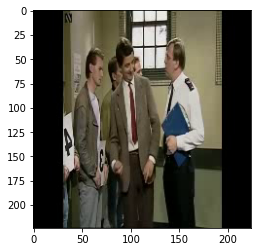

In [ ]:
plt.imshow(visible_frame[3])

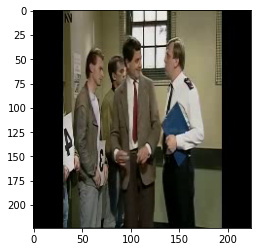

In [ ]:
plt.imshow(visible_frame[15])

**Pre-Trained Model: RESNET101**

In [ ]:
# image_model = ResNet101V2(include_top=True, weights='imagenet')

image_model = tf.keras.applications.ResNet101V2(
    include_top=True,
    weights="imagenet"
)

179527680/179518384 [==============================] - 2s 0us/step


**The model summary**

In [ ]:
image_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:

input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

**RESNET101 model flowchart**

In [ ]:
# We will use the output of the layer prior to the final
# classification-layer which is named probs. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the RESNET101 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of RESNET101 net have dimensions: ", transfer_values_size)

The input of the RESNET101 net have dimensions: (224, 224)
The output of the selecter layer of RESNET101 net have dimensions:  2048


**Function to process 20 video frames through RESNET101 and get transfer value**

In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (40,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (40, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values


**Generator that process one video through RESNET101 each function call**

USED in make_files and make_files_test

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (40,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (40, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([40,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

**Functions to save transfer values from RESNET101 to later use**

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

             # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir_2, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

**Split the dataset into training set and test set**

The training set is used to train the model and the test set to check the model accuracy.

In [ ]:
in_dir_2 = '/content/drive/My Drive/Colab Notebooks/TESTING_DATASET_VIOLENCE'
print(in_dir_2)
names2, labels2 = label_video_names(in_dir_2)
#names2 = video_names(in_dir_2)
print ("Done!")

/content/drive/My Drive/Colab Notebooks/TESTING_DATASET_VIOLENCE
Done!


In [ ]:
training_set = int(len(names))
test_set = int(len(names2))

names_training = names[0:training_set]
names_test = names2[0:test_set]

labels_training = labels[0:training_set]
labels_test = labels2[0:test_set]

**Processing all video frames through RESNET101 and saving the transfer values in disk**

In [ ]:
start_TV = timeit.default_timer()

make_files(training_set)

stop_TV = timeit.default_timer()

print('Time TV: ', stop_TV - start_TV)  

- Progress: 100.0%Time TV:  3643.421039964


In [ ]:
make_files_test(test_set)

- Progress: 99.3%

**Load the cached transfer values into memory**

Saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net.Training the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through ResNet101.

In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [ ]:

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=40
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:

def process_alldata_test():
    
    joint_transfer=[]
    frames_num=40
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()


In [ ]:
data_test, target_test = process_alldata_test()

In [ ]:
chunk_size = 2048
n_chunks = 40
rnn_size = 512

In [ ]:
data = np.array(data)
data_test = np.array(data_test)
target = np.array(target)
target_test = np.array(target_test)

In [ ]:
data = data.reshape(data.shape[0], n_chunks * chunk_size)
data_test = data_test.reshape(data_test.shape[0], n_chunks * chunk_size)

In [ ]:


model = Sequential()
model.add(Dense(512, input_shape=(n_chunks * chunk_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['accuracy'])

model.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               41943552  
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_19 (Activation)   (None, 2)                 0         
Total params: 41,944,578
Trainable params: 41,944,578
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 100
batchS = 500

history = model.fit(data[0:3450], target[0:3450], epochs=epoch, validation_data=(data[3450:], target[3450:]), batch_size=batchS, verbose=2)

Epoch 1/100
7/7 - 1s - loss: 0.4658 - accuracy: 0.5101 - val_loss: 0.3759 - val_accuracy: 0.6200
Epoch 2/100
7/7 - 1s - loss: 0.2431 - accuracy: 0.7554 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 3/100
7/7 - 1s - loss: 0.1952 - accuracy: 0.8041 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 4/100
7/7 - 1s - loss: 0.1903 - accuracy: 0.8090 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 5/100
7/7 - 1s - loss: 0.1878 - accuracy: 0.8110 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 6/100
7/7 - 1s - loss: 0.2167 - accuracy: 0.7823 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 7/100
7/7 - 1s - loss: 0.2223 - accuracy: 0.7774 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 8/100
7/7 - 1s - loss: 0.1795 - accuracy: 0.8203 - val_loss: 0.1600 - val_accuracy: 0.8400
Epoch 9/100
7/7 - 1s - loss: 0.1831 - accuracy: 0.8168 - val_loss: 0.1600 - val_accuracy: 0.8400
Epoch 10/100
7/7 - 1s - loss: 0.1719 - accuracy: 0.8275 - val_loss: 0.1600 - val_accuracy: 0.8400
Epoch 11/100
7/7 - 1s - loss:

**Test the model**



We are going to test the model with % of the total videos. This videos have not been used to train the network.

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

5/5 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.7933



**Print the model accuracy**

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.20665837824344635
accuracy 0.7933333516120911


PLOTING ACCURACY VS EPOCH AND LOSS VS EPOCH

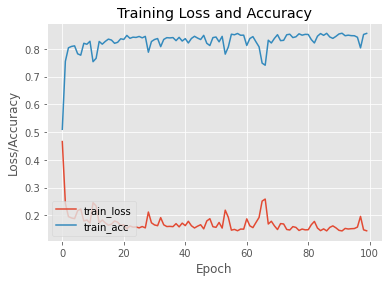

In [ ]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model_accuracy2.jpg')

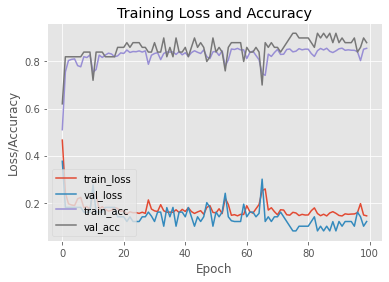

In [ ]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model_loss2.jpg')

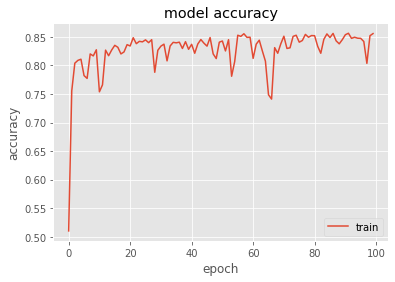

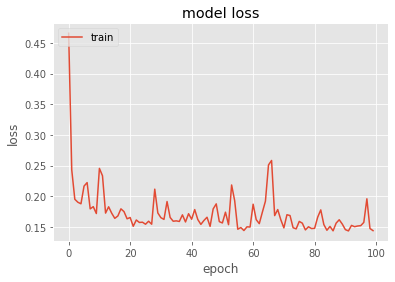

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_accuracy1.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_loss1.jpg')
plt.show()

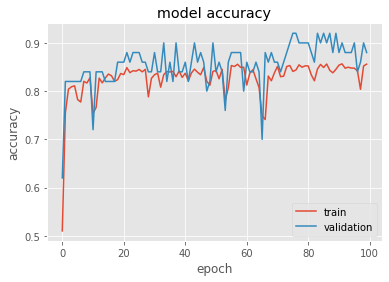

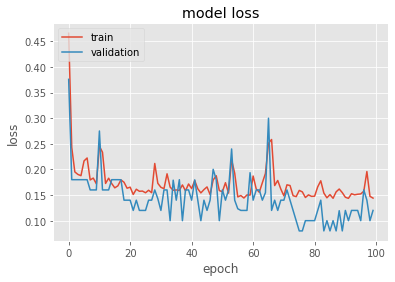

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_accuracy.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.savefig('model_loss.jpg')
plt.show()